In [2]:
import os
import shutil
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras.backend as K


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime


In [3]:

# Ruta de la carpeta de imágenes originales
original_images_path = "A. Segmentation/1. Original Images/a. Training Set/"

# Obtener todas las imágenes de la carpeta
image_files = sorted(os.listdir(original_images_path))  # Ordenar por nombre

# Crear lista para almacenar las imágenes procesadas
images = []

for img_file in image_files:
    # Cargar la imagen original
    img_path = os.path.join(original_images_path, img_file)
    img = cv2.imread(img_path)  # Leer imagen
    img_resized = cv2.resize(img, (128, 128))  # Redimensionar a 128x128
    img_normalized = img_resized.astype('float32') / 255.0  # Normalizar imagen (valores entre 0 y 1)

    # Almacenar la imagen procesada
    images.append(img_normalized)

# Convertir a un array de numpy
images = np.array(images)

# Imprimir la forma de las imágenes para verificar
print(f"Forma de las imágenes procesadas: {images.shape}")  # Debería ser (54, 128, 128, 3)


Forma de las imágenes procesadas: (54, 128, 128, 3)


In [4]:
import os
import numpy as np
import cv2

# Ruta de la carpeta de las máscaras de Hard Exudates
hard_exudates_path = "A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates/"

# Obtener todas las máscaras de la carpeta de Hard Exudates
mask_files = sorted(os.listdir(hard_exudates_path))  # Ordenar por nombre
masks = []

for mask_file in mask_files:
    # Cargar la máscara
    mask_path_full = os.path.join(hard_exudates_path, mask_file)
    mask = cv2.imread(mask_path_full, cv2.IMREAD_GRAYSCALE)  # Leer imagen en escala de grises

  

    # Redimensionar la máscara a 128x128
    mask_resized = cv2.resize(mask, (128, 128))  # Redimensionar a 128x128

    # Normalizar dividiendo entre 76 si los valores no están en el rango [0, 1]
    mask_resized = mask_resized.astype('float32') / 76.0  # Normalizar entre 0 y 1

    # Añadir un canal adicional
    mask_resized = np.expand_dims(mask_resized, axis=-1)  # Añadir el canal adicional

    # Almacenar la máscara procesada
    masks.append(mask_resized)

# Convertir a un array de numpy
processed_masks = np.array(masks)

# Imprimir la forma de las máscaras procesadas para verificar
print(f"Forma de las máscaras procesadas de Hard Exudates con canal añadido: {processed_masks.shape}")


Forma de las máscaras procesadas de Hard Exudates con canal añadido: (54, 128, 128, 1)


In [5]:
x_train=images      
y_train=processed_masks
# Imprimir las formas de los conjuntos de datos para verificar
print(f"Forma de x_train: {x_train.shape}")
print(f"Forma de y_train: {y_train.shape}")

Forma de x_train: (54, 128, 128, 3)
Forma de y_train: (54, 128, 128, 1)


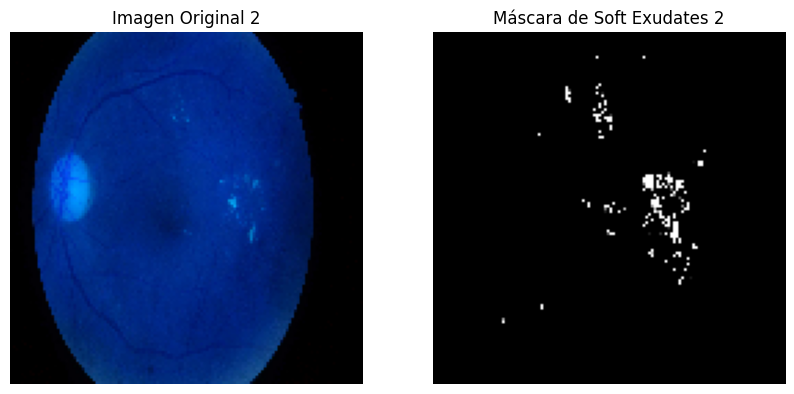

In [6]:

# Supongamos que tienes la lista de imágenes y máscaras procesadas
# Aquí seleccionamos una imagen específica (por ejemplo, la primera imagen en la lista)

index = 1 # Cambia este índice para seleccionar la imagen que deseas visualizar

# Selecciona la imagen y su máscara correspondiente
image_to_show = x_train[index]
mask_to_show = y_train[index]

# Eliminar el canal extra de la máscara
mask_to_show = mask_to_show.squeeze(axis=-1)  # Eliminar el canal extra

# Crear una figura con 1 fila y 2 columnas para mostrar la imagen y la máscara
plt.figure(figsize=(10, 5))

# Mostrar la imagen
plt.subplot(1, 2, 1)  # Fila 1, Columna 1
plt.imshow(image_to_show)
plt.title(f"Imagen Original {index + 1}")
plt.axis('off')  # No mostrar los ejes

# Mostrar la máscara
plt.subplot(1, 2, 2)  # Fila 1, Columna 2
plt.imshow(mask_to_show, cmap='gray')  # Mostrar en escala de grises
plt.title(f"Máscara de Soft Exudates {index + 1}")
plt.axis('off')  # No mostrar los ejes

# Mostrar la figura
plt.show()


In [5]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [12]:


# Definir la arquitectura U-Net
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Contracción (Encoder)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Capa intermedia (Bottleneck)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Expansión (Decoder)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs, outputs)
    return model

# Crear modelo
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Definir callbacks
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_unet_model.h5", save_best_only=True, monitor='val_loss', mode='min')
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stopping, checkpoint, tensorboard]


In [13]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=8, callbacks=callbacks)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6056 - loss: 0.6837

6/6 ━━━━━━━━━━━━━━━━━━━━ 127s 20s/step - accuracy: 0.6356 - loss: 0.6819 - val_accuracy: 0.9948 - val_loss: 0.5335
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9890 - loss: 0.3733

6/6 ━━━━━━━━━━━━━━━━━━━━ 115s 20s/step - accuracy: 0.9892 - loss: 0.3619 - val_accuracy: 0.9948 - val_loss: 0.1100
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 125s 22s/step - accuracy: 0.9886 - loss: 0.2353 - val_accuracy: 0.9948 - val_loss: 0.1322
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9900 - loss: 0.1376 

6/6 ━━━━━━━━━━━━━━━━━━━━ 146s 26s/step - accuracy: 0.9900 - loss: 0.1362 - val_accuracy: 0.9948 - val_loss: 0.0643
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9858 - loss: 0.1553 

6/6 ━━━━━━━━━━━━━━━━━━━━ 151s 27s/step - accuracy: 0.9865 - loss: 0.1491 - val_accuracy: 0.9948 - val_loss: 0.0532
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9903 - loss: 0.0886 

6/6 ━━━━━━━━━━━━━━━━━━━━ 151s 26s/step - accuracy: 0.9903 - loss: 0.0879 - val_accuracy: 0.9948 - val_loss: 0.0385
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9891 - loss: 0.0646 

6/6 ━━━━━━━━━━━━━━━━━━━━ 172s 31s/step - accuracy: 0.9893 - loss: 0.0634 - val_accuracy: 0.9948 - val_loss: 0.0318
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9917 - loss: 0.0432 

6/6 ━━━━━━━━━━━━━━━━━━━━ 154s 27s/step - accuracy: 0.9915 - loss: 0.0438 - val_accuracy: 0.9948 - val_loss: 0.0289
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9889 - loss: 0.0514 

6/6 ━━━━━━━━━━━━━━━━━━━━ 146s 26s/step - accuracy: 0.9891 - loss: 0.0505 - val_accuracy: 0.9948 - val_loss: 0.0287
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 195s 36s/step - accuracy: 0.9892 - loss: 0.0505 - val_accuracy: 0.9948 - val_loss: 0.0291
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 120s 21s/step - accuracy: 0.9912 - loss: 0.0435 - val_accuracy: 0.9948 - val_loss: 0.0357
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 130s 23s/step - accuracy: 0.9910 - loss: 0.0471 - val_accuracy: 0.9948 - val_loss: 0.0293


In [6]:

# Procesamiento de imágenes de prueba
def load_and_process_images(image_dir, mask_dir, image_size=(128, 128)):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    x_test = []
    y_test = []
    
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalización
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, image_size)
        mask = np.expand_dims(mask, axis=-1)  # Añadir canal
        mask = mask / 76.0  # Normalización específica
        
        x_test.append(img)
        y_test.append(mask)
    
    return np.array(x_test), np.array(y_test)

# Rutas de test
test_images_path = "A. Segmentation/1. Original Images/b. Testing Set/"
test_masks_path = "A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates/"

# Cargar y procesar los datos de prueba
x_test, y_test = load_and_process_images(test_images_path, test_masks_path)

print("Forma de x_test:", x_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de x_test: (27, 128, 128, 3)
Forma de y_test: (27, 128, 128, 1)


In [15]:
# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.9884 - loss: 0.0706
Pérdida en el conjunto de prueba: 0.0706
Precisión en el conjunto de prueba: 0.9884
